## Kinetics Model

### Prepare Packages


In [12]:
import pandas as pd
import warnings
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
import numpy as np, random
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from mordred import Calculator, descriptors
from boruta import BorutaPy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
import pickle
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score, LeaveOneOut
import shap
import torch
import gpytorch
from botorch.models.transforms import Normalize, Standardize
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from xgboost import XGBRegressor
warnings.filterwarnings('ignore')

### Train The Model

#### Load Datasets

In [13]:
df = pd.read_csv("/Users/tjalling/Desktop/Capstone_Def/svatunek_k2_dataset.csv", sep=',')
df = df.drop(columns=['Notes', 'Source'])

df.head(100)

,Compound,k2,log_k2,SMILES
0,T0919 + TCO,5.357090e+11,11.728929,O=N(=O)c2nnc(c1ncncn1)nn2
1,T0917 + TCO,4.563902e+11,11.659336,O=N(=O)c2nnc(c1ncncc1)nn2
2,T0916 + TCO,4.034550e+11,11.605795,O=N(=O)c2nnc(c1ncccn1)nn2
3,T0937 + TCO,3.525304e+11,11.547197,O=N(=O)c2nnc(C(OC)=C)nn2
4,T0913 + TCO,3.451131e+11,11.537961,O=N(=O)c2nnc(c1ncccc1)nn2
...,...,...,...,...
95,T0795 + TCO,7.902699e+10,10.897775,NC(=O)c2nnc(c1cncnc1)nn2
96,T0792 + TCO,7.876734e+10,10.896346,NC(=O)c2nnc(c1ccncc1)nn2
97,T1030 + TCO,7.862789e+10,10.895577,c1cc(N(=O)=O)ccc1c2nnc(C(=O)N)nn2
98,T0577 + TCO,7.809230e+10,10.892608,COC(=C)c2nnc(c1ncncn1)nn2


#### Add Descriptors

##### Manual Descriptors

In [ ]:

def add_molecular_descriptors_to_dataframe(df, smiles_column='SMILES'):
    """
    Add molecular descriptors to dataframe from SMILES strings
    """
    # Internet-derived descriptor List
    chosen_descriptors = ['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex', 'MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge', 'MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex', 'MinPartialCharge', 'MolLogP', 'MolMR', 'MolWt', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'RingCount', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea', 'qed']
    
    # Create calculator
    calculator = MolecularDescriptorCalculator(chosen_descriptors)
    
    # Initialize list to store all descriptor values
    all_descriptors = []
    failed_smiles = []
    
    # Process each SMILES string
    for idx, smiles in enumerate(df[smiles_column]):
        try:
            # Convert SMILES to mol object
            mol = Chem.MolFromSmiles(smiles)
            
            if mol is not None:
                # Calculate descriptors
                descriptors = list(calculator.CalcDescriptors(mol))
                all_descriptors.append(descriptors)
            else:
                # Handle invalid SMILES
                print(f"Invalid SMILES at index {idx}: {smiles}")
                all_descriptors.append([np.nan] * len(chosen_descriptors))
                failed_smiles.append(idx)
                
        except Exception as e:
            print(f"Error processing SMILES at index {idx}: {smiles}, Error: {e}")
            all_descriptors.append([np.nan] * len(chosen_descriptors))
            failed_smiles.append(idx)
    
    # Create dataframe with descriptors
    descriptors_df = pd.DataFrame(all_descriptors, columns=chosen_descriptors)
    
    # Combine with original dataframe
    result_df = pd.concat([df.reset_index(drop=True), descriptors_df], axis=1)
    
    if failed_smiles:
        print(f"Failed to process {len(failed_smiles)} SMILES")
    
    return result_df

In [15]:
# Add molecular descriptors
df_with_descriptors = add_molecular_descriptors_to_dataframe(df, smiles_column='SMILES')

# Save the enriched dataset
df_with_descriptors.to_csv('svatunek_k2_dataset_with_descriptors.csv', index=False)

df_with_descriptors = df_with_descriptors.drop(columns=['k2', "Compound"])


Successfully processed 1288 out of 1288 SMILES


In [16]:
df_with_descriptors.head()

,log_k2,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,11.728929,O=N(=O)c2nnc(c1ncncn1)nn2,2.361069,470.150519,10.673362,7.048906,7.048906,7.270857,3.613192,3.613192,...,0,0,0,0,0,0,0,0,0,0.448549
1,11.659336,O=N(=O)c2nnc(c1ncncc1)nn2,2.361069,470.598900,10.673362,7.179043,7.179043,7.270857,3.753394,3.753394,...,0,0,0,0,0,0,0,0,0,0.480491
2,11.605795,O=N(=O)c2nnc(c1ncccn1)nn2,2.361069,470.598900,10.673362,7.179043,7.179043,7.270857,3.763460,3.763460,...,0,0,0,0,0,0,0,0,0,0.480491
3,11.547197,O=N(=O)c2nnc(C(OC)=C)nn2,2.934042,334.528024,9.844935,6.667920,6.667920,6.147066,3.099108,3.099108,...,0,0,0,0,0,0,0,0,0,0.362403
4,11.537961,O=N(=O)c2nnc(c1ncccc1)nn2,2.361069,470.598900,10.673362,7.309179,7.309179,7.270857,3.903663,3.903663,...,0,0,0,0,0,0,0,0,0,0.508604


##### Morded Descriptors

In [17]:
def append_mordred_descriptors(df, smiles_column='SMILES'):
    calc = Calculator(descriptors, ignore_3D=True)
    mordred_features = []
    failed_indices = []

    for idx, smiles in enumerate(df[smiles_column]):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            try:
                desc = calc(mol)
                mordred_features.append(list(desc))
            except Exception as e:
                print(f"Error at index {idx}: {e}")
                mordred_features.append([None]*len(calc.descriptors))
                failed_indices.append(idx)
        else:
            print(f"Invalid SMILES at index {idx}: {smiles}")
            mordred_features.append([None]*len(calc.descriptors))
            failed_indices.append(idx)

    mordred_df = pd.DataFrame(mordred_features, columns=[str(d) for d in calc.descriptors])
    mordred_df.index = df.index  # Ensure indices align
    # Merge with the original DataFrame
    df_with_mordred = pd.concat([df, mordred_df], axis=1)
    return df_with_mordred

df_with_mordred = append_mordred_descriptors(df_with_descriptors, smiles_column='SMILES')

In [18]:
df_with_mordred.drop(columns=['SMILES'])

,log_k2,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,11.728929,2.361069,470.150519,10.673362,7.048906,7.048906,7.270857,3.613192,3.613192,2.242534,...,9.402035,46.702792,206.030071,12.119416,388,20,74.0,84.0,4.694444,3.388889
1,11.659336,2.361069,470.598900,10.673362,7.179043,7.179043,7.270857,3.753394,3.753394,2.375336,...,9.402035,46.702792,205.034822,11.390823,388,20,74.0,84.0,4.694444,3.388889
2,11.605795,2.361069,470.598900,10.673362,7.179043,7.179043,7.270857,3.763460,3.763460,2.353115,...,9.402035,46.702792,205.034822,11.390823,388,20,74.0,84.0,4.694444,3.388889
3,11.547197,2.934042,334.528024,9.844935,6.667920,6.667920,6.147066,3.099108,3.099108,1.908017,...,9.147081,43.579108,183.039239,10.168847,262,17,60.0,67.0,5.694444,3.055556
4,11.537961,2.361069,470.598900,10.673362,7.309179,7.309179,7.270857,3.903663,3.903663,2.495694,...,9.402035,46.702792,204.039573,10.738925,388,20,74.0,84.0,4.694444,3.388889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,8.421026,2.881556,179.999390,6.690234,4.866205,4.866205,4.325699,2.333102,2.333102,1.331806,...,8.590258,37.289972,126.065394,8.404360,90,9,40.0,43.0,3.472222,2.166667
1284,8.364626,2.827409,216.919181,8.267585,6.736068,6.736068,5.236382,3.162461,3.162461,2.168034,...,8.906935,40.567492,154.096694,7.337938,162,13,50.0,55.0,4.583333,2.611111
1285,8.311635,2.893763,203.492730,7.560478,5.813418,5.813418,4.698377,2.701136,2.701136,1.952626,...,8.815964,39.140584,140.081044,7.782280,120,11,46.0,50.0,4.333333,2.277778
1286,8.247319,2.993755,234.144710,8.483128,6.866205,6.866205,4.999019,3.333102,3.333102,3.331806,...,9.182249,41.326257,153.101445,6.959157,152,13,54.0,59.0,5.284722,2.333333


#### Clean The Data

In [ ]:
# Make a copy to avoid modifying original data
df_cleaned = df_with_mordred.copy()

# Step 1: Drop columns with >5% NaN
threshold = 0.05
nan_fraction = df_cleaned.isna().mean()
df_cleaned = df_cleaned.loc[:, nan_fraction <= threshold]

# Step 2: Drop columns with >5% inf or -inf
inf_mask = df_cleaned.applymap(lambda x: np.isinf(x) if isinstance(x, (float, int)) else False)
inf_fraction = inf_mask.mean()
df_cleaned = df_cleaned.loc[:, inf_fraction <= threshold]

# Step 3: Drop columns with any non-numeric values
def is_column_fully_float(col):
    try:
        pd.to_numeric(col, errors='raise')
        return True
    except:
        return False

float_compatible_cols = [col for col in df_cleaned.columns if is_column_fully_float(df_cleaned[col])]
df_cleaned = df_cleaned[float_compatible_cols + ['Compound', 'k2', 'log_k2', 'Source', 'Notes', 'SMILES'] if 'Compound' in df_cleaned.columns else float_compatible_cols]

# Clean feature selection (exclude both k2 and log_k2)
descriptor_columns = [col for col in df_cleaned.columns 
                     if col not in ['Compound', 'k2', 'log_k2', 'Source', 'Notes', 'SMILES']]

X = df_cleaned[descriptor_columns].fillna(0)
y = df_cleaned['log_k2']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

feature_selector = BorutaPy(RandomForestRegressor(n_jobs=-1, max_depth=None), 
                             n_estimators='auto', 
                             verbose=2, 
                             random_state=42)

feature_selector.fit(X_scaled, y)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	1367
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	117
Tentative: 	102
Rejected: 	1148
Iteration: 	9 / 100
Confirmed: 	117
Tentative: 	102
Rejected: 	1148
Iteration: 	10 / 100
Confirmed: 	117
Tentative: 	102
Rejected: 	1148
Iteration: 	11 / 100
Confirmed: 	117
Tentative: 	102
Rejected: 	1148
Iteration: 	12 / 100
Confirmed: 	125
Tentative: 	94
Rejected: 	1148
Iteration: 	13 / 100
Confirmed: 	125
Tentative: 	94
Rejected: 	1148
Iteration: 	14 / 100
Confirmed: 	125
Tentative: 	94
Rejected: 	1148
Iteration: 	15 / 100
Confirmed: 	125
Tentative: 	94
Rejected: 	1148
Iterat

BorutaPy(estimator=RandomForestRegressor(n_estimators=197, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x3158DB840),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x3158DB840,
         verbose=2)

##### Delete Useless Columns

In [20]:
# Get selected feature names from Boruta
selected_mask = feature_selector.support_
selected_features = X.columns[selected_mask]

# Subset scaled feature arrays using column names
X_selected = pd.DataFrame(X_scaled, columns=X.columns)[selected_features]

#### Split Into Train and Validation Data

##### Random Split

In [21]:
# Random split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=42
)

# Random split the data into training and test set
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    X_selected, y, 
    test_size=0.2, 
    random_state=42
)

##### Scaffold Split

In [ ]:
smiles_arr = df_with_mordred['SMILES'].values  

# Create Murcko Scaffold Function
def murcko_scaffold(smi: str) -> str:
    """Return Bemis–Murcko scaffold SMILES (no chirality)."""
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        raise ValueError(f"Bad SMILES: {smi}")
    # try Mol signature first, fall back to SMILES signature
    try:
        return MurckoScaffold.MurckoScaffoldSmiles(mol, includeChirality=False)
    except TypeError:
        return MurckoScaffold.MurckoScaffoldSmiles(smi, includeChirality=False)

# Create a 80/20 Scaffold Split 
def scaffold_split_random(smiles, frac_test=0.20, seed=42):
    """
    Allocate whole scaffold families to test set until quota reached, but shuffle scaffold order first so we don't end up with a single huge family.
    """
    random.seed(seed)
    # group row indices by scaffold
    buckets = {}
    for idx, smi in enumerate(smiles):
        scaf = murcko_scaffold(smi)
        buckets.setdefault(scaf, []).append(idx)

    # shuffle scaffold order for diversity
    scaf_items = list(buckets.items())
    random.shuffle(scaf_items)

    test_idx, train_idx = [], []
    for _, idxs in scaf_items:
        if len(test_idx) / len(smiles) < frac_test:
            test_idx.extend(idxs)
        else:
            train_idx.extend(idxs)

    # sanity-check: if still <10 scaffolds in test, force-move extra ones
    if len({murcko_scaffold(smiles[i]) for i in test_idx}) < 10:
        for scaf, idxs in scaf_items:
            if set(idxs).issubset(test_idx):   # already in test
                continue
            test_idx.extend(idxs)
            train_idx = [i for i in train_idx if i not in idxs]
            if len({murcko_scaffold(smiles[i]) for i in test_idx}) >= 10:
                break

    return np.array(train_idx), np.array(test_idx)

# Run split and slice every matrix 
X_scaled_np   = np.asarray(X_scaled)
X_selected_np = np.asarray(X_selected)
y_np          = np.asarray(y)

train_idx, test_idx = scaffold_split_random(smiles_arr, frac_test=0.20, seed=42)

X_train_scaffold            = X_scaled_np[train_idx]
X_test_scaffold             = X_scaled_np[test_idx]

X_train_scaffold_selected   = X_selected_np[train_idx]
X_test_scaffold_selected    = X_selected_np[test_idx]

y_train_scaffold            = y_np[train_idx]
y_test_scaffold             = y_np[test_idx]

# Print out the results for double checking
train_scaf = {murcko_scaffold(smiles_arr[i]) for i in train_idx}
test_scaf  = {murcko_scaffold(smiles_arr[i]) for i in test_idx}

print("Scaffold split finished")
print(f"  Train rows      : {len(train_idx)}")
print(f"  Test  rows      : {len(test_idx)}")
print(f"  Unique scaffolds")
print(f"     • train      : {len(train_scaf)}")
print(f"     • test       : {len(test_scaf)}")


Scaffold split finished
  Train rows      : 1007
  Test  rows      : 281
  Unique scaffolds
     • train      : 76
     • test       : 37


#### Train Models

##### Random Forest: Random Split Without Cleaned Data

In [23]:
# Train model
classifier_rf_rand_dirty = RandomForestRegressor(random_state=1000, n_jobs=-1, max_depth=100, n_estimators=100)
classifier_rf_rand_dirty.fit(X_train, y_train)

# Evaluate model
train_score = classifier_rf_rand_dirty.score(X_train, y_train)
test_score = classifier_rf_rand_dirty.score(X_test, y_test)

print(f"Random Split WITHOUT Cleaned Data:")
print(f"Train R²: {train_score:.3f}")
print(f"Test R²: {test_score:.3f}")

Random Split WITHOUT Cleaned Data:
Train R²: 0.985
Test R²: 0.922


##### Random Forest: Random Split With Cleaned Data

In [24]:
# Train model only on Boruta-selected features
classifier_rf_rand_clean = RandomForestRegressor(random_state=1000, n_jobs=-1, max_depth=20, n_estimators=100)
classifier_rf_rand_clean.fit(X_train_selected, y_train)

# Evaluate model
train_score = classifier_rf_rand_clean.score(X_train_selected, y_train)
test_score = classifier_rf_rand_clean.score(X_test_selected, y_test)

print(f"Random Split WITH Cleaned Data:")
print(f"Train R²: {train_score:.3f}")
print(f"Test R²: {test_score:.3f}")

Random Split WITH Cleaned Data:
Train R²: 0.986
Test R²: 0.928


##### Random Forest: Scaffold Split With Cleaned Data

In [25]:
# Train model with Boruta-selected features and scaffold split
classifier_rf_scaf_clean = RandomForestRegressor(random_state=1000, n_jobs=-1, max_depth=20, n_estimators=100)
classifier_rf_scaf_clean.fit(X_train_scaffold_selected, y_train_scaffold)

# Evaluate model
train_score = classifier_rf_scaf_clean.score(X_train_scaffold_selected, y_train_scaffold)
test_score = classifier_rf_scaf_clean.score(X_test_scaffold_selected, y_test_scaffold)
print(f"Scaffold Split WITH Cleaned Data:")
print(f"Train R²: {train_score:.3f}")
print(f"Test R²: {test_score:.3f}")

Scaffold Split WITH Cleaned Data:
Train R²: 0.987
Test R²: 0.871


##### Random Forest: Scaffold Split Without Cleaned Data

In [26]:
# Train model with all features and scaffold split
classifier_rf_scaf_dirty = RandomForestRegressor(random_state=1000, n_jobs=-1, max_depth=20, n_estimators=100)
classifier_rf_scaf_dirty.fit(X_train_scaffold, y_train_scaffold)

# Evaluate model
train_score = classifier_rf_scaf_dirty.score(X_train_scaffold, y_train_scaffold)
test_score = classifier_rf_scaf_dirty.score(X_test_scaffold, y_test_scaffold)
print(f"Scaffold Split WITHOUT Cleaned Data:")
print(f"Train R²: {train_score:.3f}")
print(f"Test R²: {test_score:.3f}")

Scaffold Split WITHOUT Cleaned Data:
Train R²: 0.987
Test R²: 0.847


##### XGBoost: Scaffold Split With Cleaned Data

In [27]:
# Train model with Boruta-selected features and scaffold split
classifier_xgb = XGBRegressor(random_state=1000, n_jobs=-1, max_depth=20, n_estimators=100)
classifier_xgb.fit(X_train_scaffold_selected, y_train_scaffold)

# Evaluate model
train_score = classifier_xgb.score(X_train_scaffold_selected, y_train_scaffold)
test_score = classifier_xgb.score(X_test_scaffold_selected, y_test_scaffold)
print(f"Scaffold Split WITH Cleaned Data (XGBoost):")
print(f"Train R²: {train_score:.3f}")
print(f"Test R²: {test_score:.3f}")

Scaffold Split WITH Cleaned Data (XGBoost):
Train R²: 1.000
Test R²: 0.860


### Understanding the Data

##### Model Evaluation

##### Calculate SHAP Values

Top 25 SHAP Feature Importances (Random Forest - Scaffold Split - Training Set):
 1. AATSC4c                        | SHAP: 0.133605
 2. fr_aniline                     | SHAP: 0.124456
 3. AATS3dv                        | SHAP: 0.068766
 4. ATSC4c                         | SHAP: 0.050653
 5. AATS3s                         | SHAP: 0.041384
 6. BCUTc-1h                       | SHAP: 0.030739
 7. GATS3c                         | SHAP: 0.029632
 8. MATS4c                         | SHAP: 0.023068
 9. AATS4dv                        | SHAP: 0.017589
10. BCUTi-1h                       | SHAP: 0.013517
11. AATS4s                         | SHAP: 0.007670
12. AATS2d                         | SHAP: 0.007546
13. GATS1Z                         | SHAP: 0.007448
14. GATS4dv                        | SHAP: 0.007028
15. Xch-7d                         | SHAP: 0.006751
16. AATSC3c                        | SHAP: 0.006639
17. AATS2s                         | SHAP: 0.006247
18. ATSC3se                        

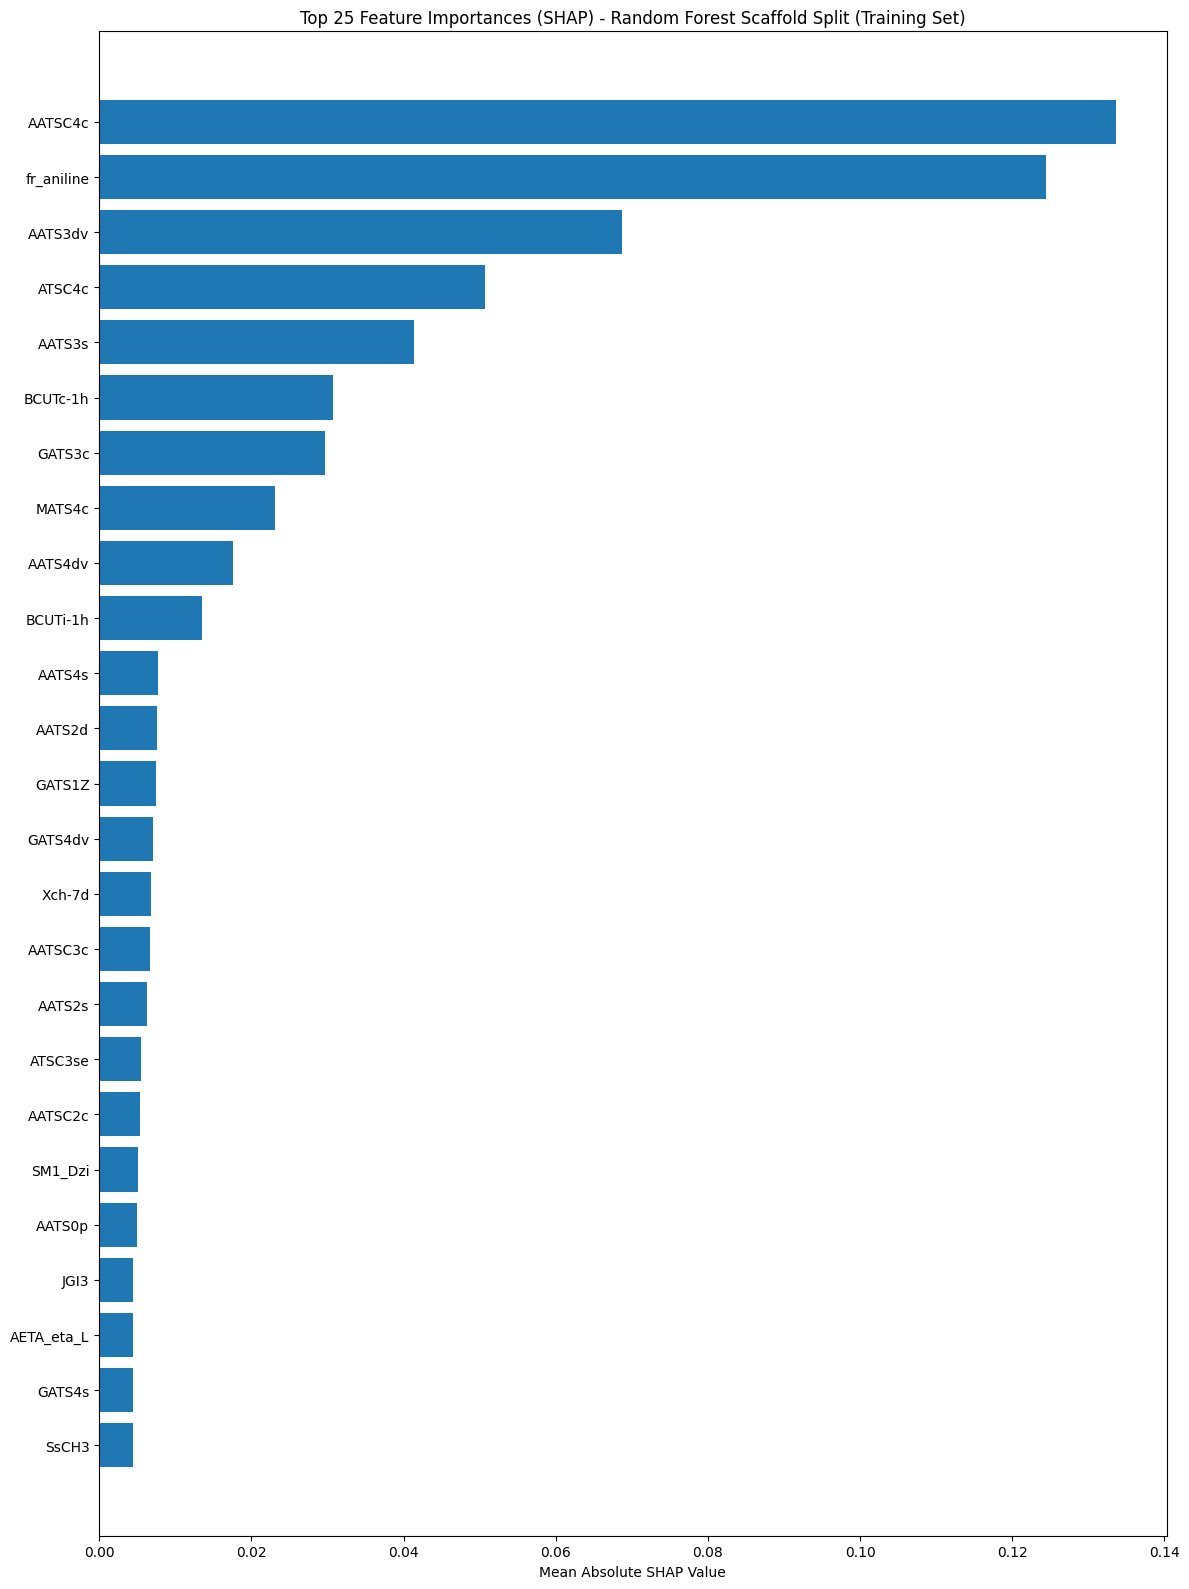

,Feature,Mean_Abs_SHAP
68,AATSC4c,0.133605
9,fr_aniline,0.124456
16,AATS3dv,0.068766
36,ATSC4c,0.050653
25,AATS3s,0.041384
112,BCUTc-1h,0.030739
96,GATS3c,0.029632
83,MATS4c,0.023068
17,AATS4dv,0.017589
116,BCUTi-1h,0.013517


In [ ]:
# Initialize SHAP for interactive plots
shap.initjs()

# Create SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(classifier_rf_scaf_clean)

# Calculate SHAP values for the training set 
shap_values = explainer(X_train_scaffold_selected)

# Get feature names from the original DataFrame 
feature_names = X_selected.columns 

# Calculate mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values.values).mean(axis=0)

# Create DataFrame with feature names and their importance
shap_importance = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Abs_SHAP': mean_shap_values
}).sort_values('Mean_Abs_SHAP', ascending=False)

# Get top 40 features
top_25_shap = shap_importance.head(25)

print("Top 25 SHAP Feature Importances (Random Forest - Scaffold Split - Training Set):")
print("=" * 70)
for i, (idx, row) in enumerate(top_25_shap.iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:30s} | SHAP: {row['Mean_Abs_SHAP']:.6f}")

plt.figure(figsize=(12, 16))
plt.barh(range(25), top_25_shap['Mean_Abs_SHAP'].iloc[::-1])
plt.yticks(range(25), top_25_shap['Feature'].iloc[::-1])
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Top 25 Feature Importances (SHAP) - Random Forest Scaffold Split (Training Set)')
plt.tight_layout()
plt.show()

# Return the DataFrame 
top_25_shap